In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import pandas as pd
import os
import sys
import cv2
import albumentations
from fastai import *
from fastai.vision import *
from fastai.vision import models
from fastai.callbacks.hooks import *
import random

from fastai.torch_core import flatten_model
from torchvision.models import *
import pretrainedmodels

In [3]:
import random

def randomizeStaining(img, Io=240, alpha=1, beta=0.15, maxC1=None, maxC2=None):
    ''' Randomize staining appearence of H&E stained images
    
    Input:
        I: RGB input image
        Io: (optional) transmitted light intensity
    
    Reference: 
        A method for normalizing histology slides for quantitative analysis. M.
        Macenko et al., ISBI 2009
    '''
             
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
        
    ε = 0.10
    θ = 4.0
    maxCRef = np.random.uniform(size=2) * θ + ε
    if maxC1 is not None:
        maxCRef[0] = maxC1
    if maxC2 is not None:
        maxCRef[1] = maxC2
    
    # define height and width of image
    h, w, c = img.shape
    
    # reshape image
    img = img.reshape((-1,3))

    # calculate optical density
    OD = -np.log((img.astype(np.float)+1)/Io)
    
    # remove transparent pixels
    ODhat = OD[~np.any(OD<beta, axis=1)]
        
    # compute eigenvectors
    eigvals, eigvecs = None,None
    try:
        eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    except AssertionError:
        return img.reshape(sz,sz,3)
    except np.linalg.LinAlgError:
        return img.reshape(sz,sz,3)
    
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3])
    
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:
        HE = np.array((vMin[:,0], vMax[:,0])).T
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])
    
    # recreate the image using reference mixing matrix
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)
    
    return Inorm

In [4]:
albumentations_transform = albumentations.Compose([
    # flips and 90deg rotates
    albumentations.RandomRotate90(p=0.5),
    albumentations.Flip(p=0.5),
    
    # brightness contrast or gamma
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
        albumentations.RandomGamma(gamma_limit=(60, 200), always_apply=True, p=1),
    ],p=1.0),
    
    # scale
    #albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=[-0.1,0.1], rotate_limit=10, p=0.5),
    
    # color alterations
    albumentations.OneOf([
        albumentations.augmentations.transforms.HueSaturationValue(hue_shift_limit=30, sat_shift_limit=30, val_shift_limit=20, always_apply=True),
        albumentations.augmentations.transforms.RGBShift(r_shift_limit=30, g_shift_limit=15, b_shift_limit=30, always_apply=True),
        albumentations.augmentations.transforms.CLAHE(p=1),
        #albumentations.augmentations.transforms.ChannelShuffle()
    ],p=0.8),
    
    # Blurring or noise
    albumentations.OneOf([
        albumentations.GaussNoise(p=0.2),
        albumentations.augmentations.transforms.Blur(p=0.2)
    ],p=1.0),
])

albumentations_transform_validation = albumentations.Compose([
    #albumentations.RandomRotate90(p=0.5),
    #albumentations.Transpose(p=0.5),
])

## Multilevel dataloader
First, we need a way to yield two image inputs from a data loder.

In [5]:
def loadDfForFold(fold_index = 0):
    df = pd.read_csv('data/training/center_4.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)
    df['is_valid'] = True
    return df

In [6]:
df = loadDfForFold(0)
sz = 256
BATCH_SIZE = 28
NUM_WORKERS = 16
model_name = '20190826-21-pretrained_multilevel_Test'

In [7]:
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.obj,self.data = (img1,img2),[-1+2*img1.data,-1+2*img2.data]
        
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, **kwargs)
        self.data = [-1+2*self.img1.data,-1+2*self.img2.data]
        return self
    
    def to_one(self): 
        return Image(0.5+torch.cat(self.data,2)/2)
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`. 
        `kwargs` are passed to the show method."""
        figsize = fai.ifnone(figsize, (6,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
            x.show(ax=axs[i,0], y=y, **kwargs)
            x.show(ax=axs[i,1], y=z, **kwargs)
    
    def __repr__(self):
        return f'{self.__class__.__name__}{(self.img1.shape, self.img2.shape)}'

In [8]:
class ImageTupleList(ImageList):
    def __init__(self, items, df_copy=None, validation_colname="", data_dir='',data_suffix=[],last_fn='', **kwargs):
        super().__init__(items, **kwargs)
        self.df_copy,self.validation_colname,self.data_dir,self.data_suffix = df_copy,validation_colname,data_dir,data_suffix
        self.last_fn = last_fn
        if(df_copy is None):
            print('Empty df copy')
        self.copy_new.append('df_copy')
        self.copy_new.append('validation_colname')
        self.copy_new.append('data_dir')
        self.copy_new.append('data_suffix')
        self.copy_new.append('last_fn')
    
    def get(self, i):
        # keep random state to apply the same augmentations for both images
        random_state = random.getstate()
        np_random_state = np.random.get_state()
        img1 = super().get(i)
        random.setstate(random_state)
        np.random.set_state(np_random_state)
        img2 = self.open(self.last_fn)
        return ImageTuple(img1, img2)
    
    def open(self, fn)->Image:
        self.last_fn = fn.replace(self.data_suffix[0], self.data_suffix[1])
        img = cv2.imread(fn)
        # Apply transformations
        img = img if (self.df_copy.loc[int(fn.strip(self.data_dir).replace(self.data_suffix[0],'').replace(self.data_suffix[1],''))][self.validation_colname]).any() else randomizeStaining(img)
        augmented = albumentations_transform_validation(image=img) if (self.df_copy.loc[int(fn.strip(self.data_dir).replace(self.data_suffix[0],'').replace(self.data_suffix[1],''))][self.validation_colname]).any() else albumentations_transform(image=img)
        # Convert numpy array to tensor
        return vision.Image(px=pil2tensor(augmented['image']/255., np.float32))
    
    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))
    
    @classmethod
    def from_df_custom(cls, df:DataFrame, path:PathOrStr, cols:IntsOrStrs=0, folder:PathOrStr=None, suffix=[], **kwargs)->'ItemList':
        "Get the filenames in `cols` of `df` with `folder` in front of them, `suffix` at the end."
        suffix = suffix or []
        res = super().from_df(df, path=path, cols=cols, **kwargs, data_dir=path, data_suffix=suffix)
        pref = f'{res.path}{os.path.sep}'
        if folder is not None: pref += f'{folder}{os.path.sep}'
        res.items = np.char.add(np.char.add('', res.items.astype(str)), '_0.png')
        return res
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)

In [9]:
multiLevelList = (ImageTupleList.from_df_custom(path='data/test_patches/',
                                            df=df,
                                            suffix=['_0.png','_2.png'], 
                                            df_copy=df,
                                            validation_colname='is_valid')
                    .split_none()
                    #How to split in train/valid? CV index
                    .label_from_df(cols='tumorLabel')
                    #Where are the labels?
                    .transform(tfms=[[],[]], size=sz)
                    # We have our custom transformations implemented in the image loader but we could apply transformations also here
                    # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
                    .databunch(bs=BATCH_SIZE, num_workers=NUM_WORKERS))
                    # convert to databunch

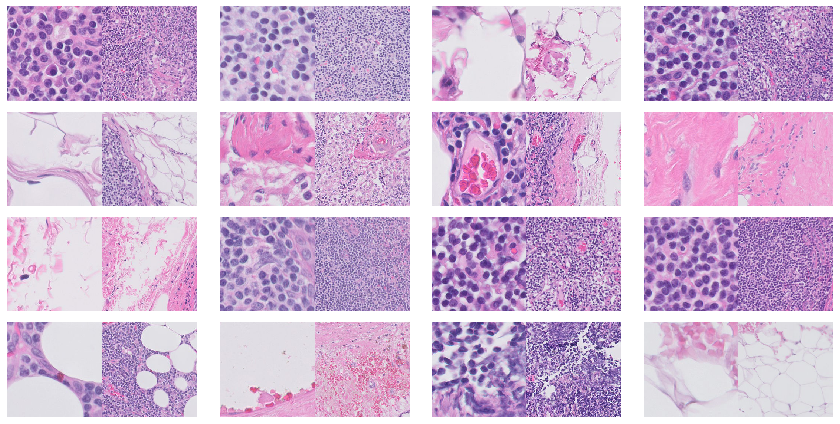

In [10]:
multiLevelList.show_batch(rows=4,ds_type=DatasetType.Train)

## Model

In [11]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []
        
class FakeData:
    def __init__(self):
        self.c = 2
        self.path = ''    
        self.device = None
        self.loss_func = CrossEntropyFlat(axis=1)

In [12]:
# we wrap cadene model to pytorch models format
def se_resnext101_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['se_resnext101_32x4d'](pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers)

In [13]:
# we wrap cadene model to pytorch models format
def se_resnext50_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['se_resnext50_32x4d'](pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers)

In [14]:
arch_summary(se_resnext50_32x4d)

(0) Sequential  : 4   layers (total: 4)
(1) Sequential  : 38  layers (total: 42)
(2) Sequential  : 50  layers (total: 92)
(3) Sequential  : 74  layers (total: 166)
(4) Sequential  : 38  layers (total: 204)
(5) AvgPool2d   : 1   layers (total: 205)
(6) Linear      : 1   layers (total: 206)


In [15]:
arch_summary(se_resnext101_32x4d)

(0) Sequential  : 4   layers (total: 4)
(1) Sequential  : 38  layers (total: 42)
(2) Sequential  : 50  layers (total: 92)
(3) Sequential  : 278 layers (total: 370)
(4) Sequential  : 38  layers (total: 408)
(5) AvgPool2d   : 1   layers (total: 409)
(6) Linear      : 1   layers (total: 410)


### Pretrained context encoder

In [ ]:
class UpSample(nn.Module):
    def __init__(self,feat_in,feat_out,out_shape=None,scale=2):
        super().__init__()
        self.conv = nn.Conv2d(feat_in,feat_out,kernel_size=(3,3),stride=1,padding=1)
        self.out_shape,self.scale = out_shape,scale
        
    
    def forward(self,x):
        return self.conv(
            nn.functional.interpolate(
                x,size=self.out_shape,scale_factor=self.scale,mode='bilinear',align_corners=True))

In [ ]:
def get_upSamp(feat_in,feat_out, out_shape=None, scale=2, act='relu'):
    
    upSamp = UpSample(feat_in,feat_out,out_shape=out_shape,scale=scale).cuda()
    
    layer = nn.Sequential(upSamp)
    
    if act == 'relu':
        act_f = nn.ReLU(inplace=True).cuda()
        bn = nn.BatchNorm2d(feat_out).cuda()
        layer.add_module('ReLU',act_f)
        layer.add_module('BN',bn)
    elif act == 'sig':
        act_f = nn.Sigmoid()
        layer.add_module('Sigmoid',act_f)
    return layer

def add_layer(m,feat_in,feat_out,name,out_shape=None,scale=2,act='relu'):
    upSamp = get_upSamp(feat_in,feat_out,out_shape=out_shape,scale=scale,act=act)
    m.add_module(name,upSamp)

In [ ]:
def getPretrainedEncoder():
    df = pd.read_csv('data/training/train_val.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)
    data_folder = './data/norm_patches/'
    paths = [data_folder + str(patch) + '_2.png' for patch in df.patchId]
    df['path'] = paths
    df = df.set_index('path',drop=False)
    df = df.drop(columns=['patchId','fileName','center','node','centerX','centerY',
                          'isTumor','tumorPercentage','tissuePercentage','meanHue',
                         'patient','meanSaturation','meanValue','tumorLabel'])
    db = (ImageImageList.from_df(df=df,path='.')
      .split_by_rand_pct(0.2)
      .label_from_df('path')
      .transform(tfms=[[],[]], size=sz)
      .databunch(bs=BATCH_SIZE, num_workers=NUM_WORKERS)
      .normalize(imagenet_stats))
    
    encoder = se_resnext50_32x4d(pretrained=True).cuda()
    # drop   (5): AvgPool2d(kernel_size=7, stride=1, padding=0)
    #        (6): Linear(in_features=2048, out_features=1000, bias=True)
    encoder = encoder[:5]
    
    code_sz = 64
    conv = nn.Conv2d(2048, code_sz, kernel_size=(2,2)).cuda()
    encoder.add_module('CodeIn',conv)
    
    add_layer(encoder,code_sz,512,'CodeOut',out_shape=(16,16),scale=None)
    add_layer(encoder,512,256,'Upsample0')
    add_layer(encoder,256,128,'Upsample1')
    add_layer(encoder,128,64,'Upsample2')
    add_layer(encoder,64,3,'Upsample3',act='sig')
    
    learner_encoder = Learner(db,encoder,loss_func=F.mse_loss)
    learner_encoder.split(lambda m: (m[4],m[5]))
    learner_encoder.load('20190827-Autoencoder_se_resnext50_lvl2_aug_finetuned4')
    
    #learner_encoder.freeze()
    
    return learner_encoder.model[:5]

In [ ]:
class MultiLevelModel(nn.Module):
    def __init__(self):
        super().__init__()
        # focus encoder outputs more features that are also more relevant to the label
        self.focus_encoder = nn.Sequential(create_body(se_resnext101_32x4d, pretrained=True, cut=-2), nn.AdaptiveAvgPool2d(1))
                                          
        # context encoder is a lighter CNN that outputs less features from the surrounding area
        #self.context_encoder = nn.Sequential(create_body(se_resnext50_32x4d, pretrained=True, cut=-2), nn.AdaptiveAvgPool2d(1))
        self.context_encoder = nn.Sequential(getPretrainedEncoder(), nn.AdaptiveAvgPool2d(1))
    
        # head comes after concatenating the encoder outputs
        head_inp_sz = num_features_model(self.context_encoder) + num_features_model(self.focus_encoder)

        self.head = create_head(nf=head_inp_sz, nc=2 , ps=0.9, lin_ftrs=[2048,512])[2:]

    def forward(self, x1, x2):
        forward_1 = torch.cat(
            (
                self.focus_encoder(x1),
                self.context_encoder(x2)
            ),
            1
        )
        forward_1 = torch.reshape(forward_1,(forward_1.shape[0], -1))
        forward_2 = self.head(forward_1)
        return forward_2

## Train

In [ ]:
def getDataBunch(fold_index = 0):
    df = loadDfForFold(fold_index)
    return (ImageTupleList.from_df_custom(path='data/test_patches/',
                                            df=df,
                                            suffix=['_0.png','_2.png'], 
                                            df_copy=df,
                                            validation_colname='is_valid')
                    .split_none()
                    #How to split in train/valid? CV index
                    .label_from_df(cols='tumorLabel')
                    #Where are the labels?
                    .transform(tfms=[[],[]], size=sz)
                    # We have our custom transformations implemented in the image loader but we could apply transformations also here
                    # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
                    .databunch(bs=BATCH_SIZE, num_workers=NUM_WORKERS))
                    # convert to databunch

In [ ]:
def getLearner(multiLevelList):
    loss_func = nn.CrossEntropyLoss()
    learner = Learner(multiLevelList, 
                      MultiLevelModel(),
                      loss_func=loss_func, 
                      metrics=[accuracy], 
                      callback_fns=ShowGraph)
    
    return learner

In [ ]:
from sklearn.metrics import roc_curve, auc

# saved for validation
preds_list = []
y_list = []

tpr_list = []
fpr_list = []
roc_auc_list = []

recorder_stage1_list = []

df_inference = pd.read_csv('data/training/center_4.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)

for fold in range(5):
    print("##########################")
    print("Start Test inference - " + str(fold))
    print("##########################")
    
    # get fold databunch
    fold_databunch = getDataBunch(fold_index=fold)
    
    # init new learner
    learner = getLearner(fold_databunch)
    
    # load trained weights
    # multilevel models have saved their weights to data folder
    learner.load('./../../patches/models/' + model_name + '_test' + str(fold) + '_stage-1')
    
    # get preds for train set
    preds,y = learner.get_preds(ds_type=DatasetType.Fix) # Fix is the training dataset with the last batch included and no shuffle 
    
    # probs from log preds
    probs = np.exp(preds[:,1])
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    # Compute ROC area
    roc_auc = auc(fpr, tpr)
    print('ROC area of the Test {1} is {0}'.format(roc_auc, fold))
    
    roc_auc_list.append(roc_auc)
    
    # write to df
    df_inference['tumorProbs_' + str(fold)] = probs
df_inference.to_csv('./data/test_inference/' + model_name + '_test' + '_center_4_inference.csv') 

##########################
Start Test inference - 0
##########################


/home/jonijuvonen/.conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type UpSample. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jonijuvonen/.conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MultiLevelModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [36]:
for fold , auc in enumerate(roc_auc_list):
    print('The AUC of the test {1} model is {0} %.'.format(auc*100, fold))
print('The average AUC of all tests is {0} %'.format(np.asarray(roc_auc_list).mean()*100))
print('The std (ddof=1) of AUC of all tests is {0} %'.format(np.asarray(roc_auc_list).std(ddof=1)*100))

The AUC of the test 0 model is 95.60824311200608 %.
The AUC of the test 1 model is 96.64622617462702 %.
The AUC of the test 2 model is 95.66342016037413 %.
The AUC of the test 3 model is 95.26495322195377 %.
The AUC of the test 4 model is 95.39905309717106 %.
The average AUC of all tests is 95.7163791532264 %
The std (ddof=1) of AUC of all tests is 0.5439657017724832 %


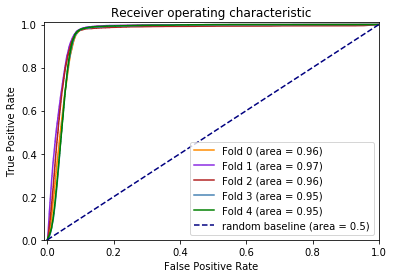

In [37]:
plt.figure()
color_str = ['darkorange', 'blueviolet', 'firebrick', 'steelblue', 'green']
for i, f in enumerate(fpr_list):
    plt.plot(fpr_list[i], tpr_list[i], color=color_str[i], label='Fold %d (area = %0.2f)' % (i, roc_auc_list[i]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random baseline (area = 0.5)')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

## Patient level analysis

In [38]:
df_inference = pd.read_csv('./data/test_inference/' + model_name + '_test' + '_center_4_inference.csv').set_index('patchId.1').set_index('patchId',drop=False)
df_inference.head()

,patchId,fileName,center,patient,node,centerX,centerY,isTumor,tumorPercentage,tissuePercentage,meanHue,meanSaturation,meanValue,tumorLabel,tumorProbs_0,tumorProbs_1,tumorProbs_2,tumorProbs_3,tumorProbs_4
patchId,,,,,,,,,,,,,,,,,,,
96000017920093952,96000017920093952,data/training/center_4/patient_096_node_1.tif,4,96,1,1792,93952,False,0.0,6.2,0.80,0.13,0.85,False,1.013984,1.016975,1.015038,1.088422,1.012242
96000024320092288,96000024320092288,data/training/center_4/patient_096_node_1.tif,4,96,1,2432,92288,False,0.0,20.3,0.79,0.17,0.85,False,1.003485,1.008721,1.000000,1.001184,1.006082
96000023040092416,96000023040092416,data/training/center_4/patient_096_node_1.tif,4,96,1,2304,92416,False,0.0,20.7,0.79,0.17,0.85,False,1.004175,1.009729,1.000000,1.004004,1.005516
96000026880098176,96000026880098176,data/training/center_4/patient_096_node_1.tif,4,96,1,2688,98176,False,0.0,33.5,0.83,0.10,0.85,False,1.003621,1.014759,1.000000,1.005956,1.009104
96000028160098304,96000028160098304,data/training/center_4/patient_096_node_1.tif,4,96,1,2816,98304,False,0.0,32.0,0.85,0.10,0.83,False,1.005187,1.010693,1.000000,1.007421,1.005533


In [39]:
all_patients = np.unique(df_inference.patient)

In [40]:
cancer_slides = []
for patient in all_patients:
    for node in range(5):
        df_sub = df_inference[df_inference.patient == patient]
        df_sub = df_sub[df_sub.node == node]
        if True in np.unique(df_sub.isTumor):
            cancer_slides.append((patient,node))

In [41]:
import sklearn
from sklearn.metrics import roc_curve, auc

patient_auc_arr = np.zeros((len(cancer_slides)*4,5),dtype=np.float64)
patient_fprs = []
patient_tprs = []
patient_aucs = []
y, prob = None,None
for i,(patient,node) in enumerate(cancer_slides):
    df_patient = df_inference[df_inference.patient == patient]
    df_patient = df_patient[df_patient.node == node]
    y = df_patient.isTumor.values.astype(int)
    probs_list = []
    # get individual tests
    for test in range(5):
        probs = df_patient['tumorProbs_' + str(test)].values
        probs_list.append(probs)
        fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        patient_auc_arr[i,test] = roc_auc
    # get average of the tests
    prob = np.mean(np.array(probs_list),axis=0)
    fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)
    patient_fprs.append(fpr)
    patient_tprs.append(tpr)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    patient_aucs.append(roc_auc)
    print('Patient_{0} node_{1} auc: {2}'.format(patient,node,roc_auc))

Patient_81 node_4 auc: 0.8687398183285633
Patient_88 node_1 auc: 0.9007251700379663
Patient_99 node_4 auc: 0.983352689353379


In [42]:
for fold , auc in enumerate(patient_aucs):
    print('The average AUC of the patient {1} with models is {0} %.'.format(auc*100, cancer_slides[fold][0]))
print('The average AUC of all tumor patients is {0} %'.format(np.asarray(patient_aucs).mean()*100))
print('The std (ddof=1) of AUC of all tumor patients is {0} %'.format(np.asarray(patient_aucs).std(ddof=1)*100))

The average AUC of the patient 81 with models is 86.87398183285633 %.
The average AUC of the patient 88 with models is 90.07251700379662 %.
The average AUC of the patient 99 with models is 98.33526893533791 %.
The average AUC of all tumor patients is 91.7605892573303 %
The std (ddof=1) of AUC of all tumor patients is 5.91417504485962 %


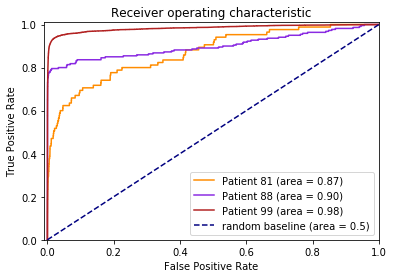

In [43]:
plt.figure()
color_str = ['darkorange', 'blueviolet', 'firebrick', 'steelblue', 'green']
for i, f in enumerate(patient_fprs):
    plt.plot(patient_fprs[i], patient_tprs[i], color=color_str[i], label='Patient %d (area = %0.2f)' % (cancer_slides[i][0], patient_aucs[i]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random baseline (area = 0.5)')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

## Heatmap

In [44]:
# add ASAP path to sys to locate the multiresolutionimageinterface
import sys
sys.path.append('/opt/ASAP/bin')
# required libraries
import multiresolutionimageinterface as mir

imagePaths = ['./data/training/center_4/patient_081_node_4.tif',
             './data/training/center_4/patient_088_node_1.tif',
             './data/training/center_4/patient_099_node_4.tif']
maskPaths = [x.replace('.tif', '_mask.tif') for x in imagePaths]

reader = mir.MultiResolutionImageReader()

In [45]:
wsi_patient_nodes = [[81,4],[88,1],[99,4]]

In [46]:
def getSlide(slide, mask_level=5):
    ds = slide.getLevelDownsample(mask_level)
    original_tissue = slide.getUCharPatch(0,
                                         0,
                                         int(slide.getDimensions()[0] / float(ds)),
                                         int(slide.getDimensions()[1] / float(ds)),
                                         mask_level)
    return original_tissue

def getTrueMask(slide, mask_level=5):
    ds = slide.getLevelDownsample(mask_level)
    tumor_mask = slide.getUCharPatch(0,
                                     0,
                                     int(slide.getDimensions()[0] / float(ds)),
                                     int(slide.getDimensions()[1] / float(ds)),
                                     mask_level)
    # convert to binary
    tumor_mask = np.array(tumor_mask*255, np.uint8)
    return tumor_mask.reshape(tumor_mask.shape[:2])

def getTumorMask(width, height, patient, node, mask_level=5, threshold=0.5):
    downsamp = pow(2,mask_level)
    tumor = np.zeros((int(round(width/downsamp)), int(round(height/downsamp))), np.uint8)
    half_window = int(round(256/(2*downsamp)))
    
    # five models each pixel can overlap with two windows
    # This gives 10 possible additions per pixel. 
    # 255 is the max so each model can add a max of 25.5 -> ~25
    df_sub = df_inference[df_inference.patient==patient]
    df_sub = df_sub[df_sub.node==node]
    for idx in tqdm_notebook(df_sub.index.values):
        for test in range(5):
            prob = int((np.log(df_sub.loc[idx]['tumorProbs_' + str(test)])) * 25)
            centerX = int(round(df_sub.loc[idx]['centerX'] / downsamp))
            centerY = int(round(df_sub.loc[idx]['centerY'] / downsamp))
            tumor[centerX-half_window:centerX+half_window, centerY-half_window:centerY+half_window] += prob
    median_kernel_sz = int(15*5/mask_level)
    if median_kernel_sz % 2 == 0:
        median_kernel_sz += 1
    tumor = cv2.medianBlur(tumor, median_kernel_sz)
    # threshold
    if threshold is not None:
        th = int(threshold*255)
        tumor = cv2.threshold(tumor, th, 255,cv2.THRESH_BINARY)[1]
    return tumor

def calculateIoU(true_mask,pred_mask, eps = 1E-9):
    intersection = np.sum(cv2.bitwise_and(true_mask//255,pred_mask//255))
    union = np.sum(cv2.bitwise_or(true_mask//255,pred_mask//255))    
    return (intersection + eps)/(union + eps)

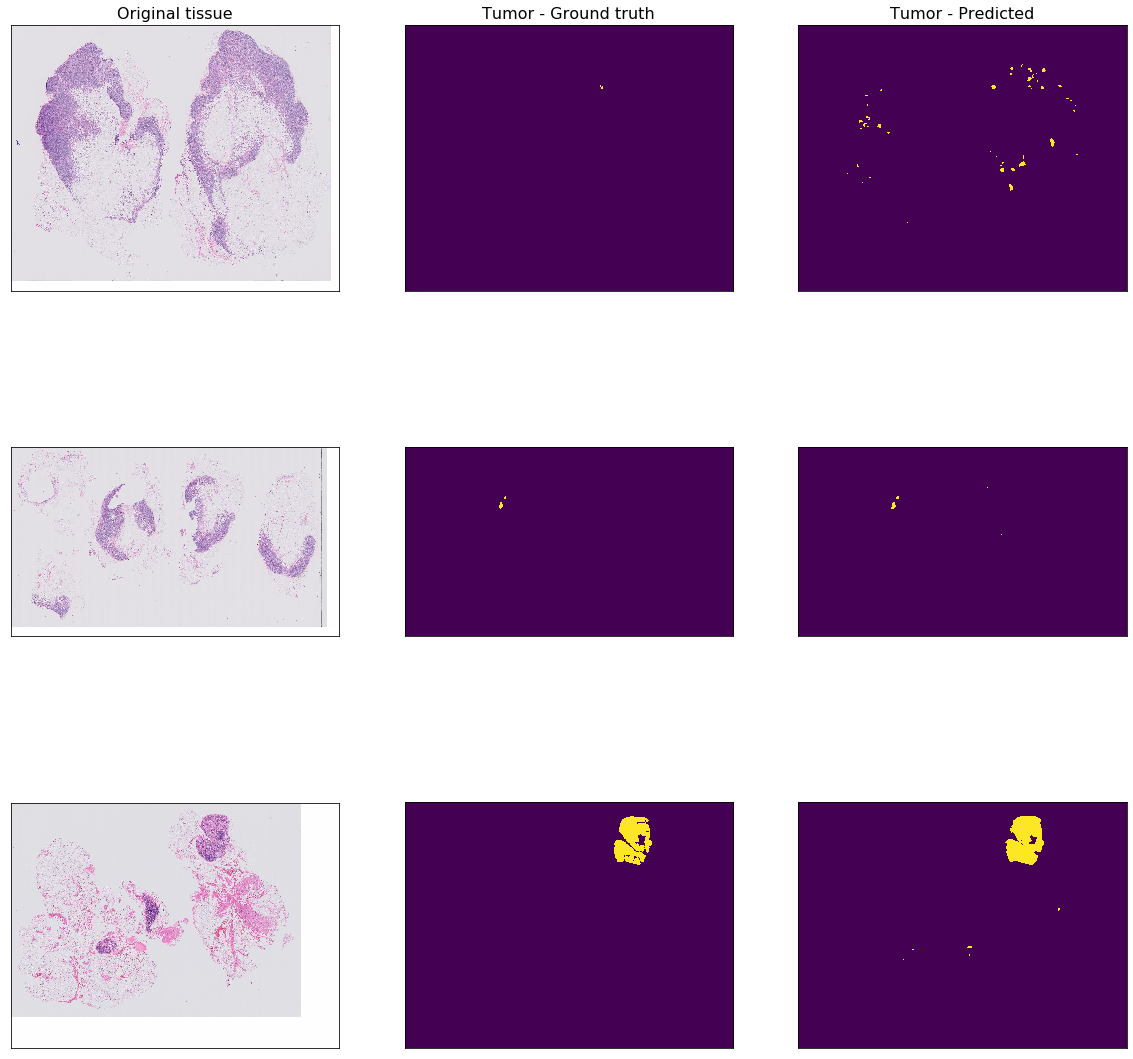

In [47]:
# plot all tumor WSI's
from tqdm import tqdm_notebook
f, ax = plt.subplots(3,3,figsize = (20,20))
IoUs = []
for i in range(len(imagePaths)):
    mr_image = reader.open(imagePaths[i])
    mr_mask = reader.open(maskPaths[i])
    
    ax[i,0].imshow(getSlide(mr_image))
    
    true_mask = getTrueMask(mr_mask)
    ax[i,1].imshow(true_mask)
    
    pred_mask = getTumorMask(mr_image.getDimensions()[1],
                             mr_image.getDimensions()[0], 
                             wsi_patient_nodes[i][0],
                             wsi_patient_nodes[i][1],
                             mask_level=5)
    
    IoU = calculateIoU(true_mask, pred_mask)
    IoUs.append(IoU)
    
    ax[i,2].imshow(pred_mask)
    
    for j in range(3):
        ax[i,j].xaxis.set_major_locator(plt.NullLocator())
        ax[i,j].yaxis.set_major_locator(plt.NullLocator())
    
    if i == 0:
        ax[0,0].set_title('Original tissue', fontsize=16)
        ax[0,1].set_title('Tumor - Ground truth', fontsize=16)
        ax[0,2].set_title('Tumor - Predicted', fontsize=16)

In [48]:
print(IoUs)
print("Average IoU: {0}".format(np.mean(np.array(IoUs))))

[0.02248703302478424, 0.702992478796655, 0.8359164031666176]
Average IoU: 0.520465304996019
